# Описание проекта

Помощь коллегам - всегда благое дело. В данном проекте с использованием моделей машинного обучения будут предсказаны уровень удовлетворенности сотрудника и предсказано увольнение из компании, что поможет HR-ам своевременно и грамотно среагировать на сложившуюся ситуацию в компании

# Задача 1: предсказание уровня удовлетворённости сотрудника

Для этой задачи заказчик предоставил данные с признаками:

    id — уникальный идентификатор сотрудника;
    dept — отдел, в котором работает сотрудник;
    level — уровень занимаемой должности;
    workload — уровень загруженности сотрудника;
    employment_years — длительность работы в компании (в годах);
    last_year_promo — показывает, было ли повышение за последний год;
    last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
    supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
    salary — ежемесячная зарплата сотрудника;
    job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

## Шаг 1. Загрузка данных

In [37]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [38]:
!pip install -U scikit-learn -q

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer


from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler,
    LabelEncoder
)

from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier


In [40]:
train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
display(train.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [41]:
test = pd.read_csv('/datasets/test_features.csv')
display(test.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [42]:
target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
display(target.head())

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Объединим табоицы с входными признаками тестовой выборки и целевым для дальнейшей работы с одним датасетом.

In [43]:
test = test.merge(target, on='id', how='left')
display(test.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


## Шаг 2. Предобработка данных

Выведем общую информацию об имеющихся таблицах:

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [45]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 171.9+ KB


С типами данных все в порядке, однако стоит посмотреть, какие именно значения есть в каждом из столбцов:

In [46]:
categorical_columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
for column in categorical_columns:
    train[column] = train[column].str.lower()
    print(f'Уникальные значения в столбце {column}: {train[column].unique()}')

Уникальные значения в столбце dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Уникальные значения в столбце level: ['junior' 'middle' 'sinior' nan]
Уникальные значения в столбце workload: ['medium' 'high' 'low']
Уникальные значения в столбце last_year_promo: ['no' 'yes']
Уникальные значения в столбце last_year_violations: ['no' 'yes']


In [47]:
train['level'] = train['level'].replace('sinior', 'senior')
train['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [48]:
categorical_columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
for column in categorical_columns:
    test[column] = test[column].str.lower()
    print(f'Уникальные значения в столбце {column}: {test[column].unique()}')

Уникальные значения в столбце dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уникальные значения в столбце level: ['junior' 'middle' 'sinior' nan]
Уникальные значения в столбце workload: ['medium' 'low' 'high' ' ']
Уникальные значения в столбце last_year_promo: ['no' 'yes']
Уникальные значения в столбце last_year_violations: ['no' 'yes']


In [49]:
test['level'] = test['level'].replace('sinior', 'senior')
test['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

В каждом из имеющихся датасетов были исправлены опечатки, а также замечены пропуски двух типов: пробел вместо значения и nan-значения. Последние будут обработы в пайплайне, а пропуски, предсатвляющие из себя пробел, - данные, необходимые для обучения модели и предказания с ее помощью, их стоит оставить as they are. 

Проверим датасеты на наличие явных дубликатов:

In [50]:
train.duplicated().sum()

0

In [51]:
test.duplicated().sum()

0

Как следует из выводов двух строк кода, явных дубликатов в таблицах нет. Остался последний шаг: удалить столбец 'id', так как он логически никак не связан с целевым признаком.

In [52]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

Посмотрим, появились ли явные дубликаты после удаления этого столбца:

In [53]:
train.duplicated().sum()

245

In [54]:
test.duplicated().sum()

83

Из тестовых данных удалять дубликаты нельзя, так как нужно предсказать значения для каждого элемента, неходящегося в таблице, чего нельзя сказать о тренировочных данных, ведь от количества дубликатов зависит качество обучения модели:

In [55]:
train = train.drop_duplicates()
train.duplicated().sum()

0

Данные в полном порядке, можем приступать к дальнейшей работе с ними!

## Шаг 3. Исследовательский анализ данных

Посмотрим, каково распределение данных в тренировочной и тестовой выборках, для того, чтобы понять, адекватны ли будут предсказания модели:

In [56]:
numeric_columns = ['employment_years', 'supervisor_evaluation', 'salary']
non_numeric_columns = ['dept', 'last_year_promo', 'last_year_violations', 'level', 'workload']

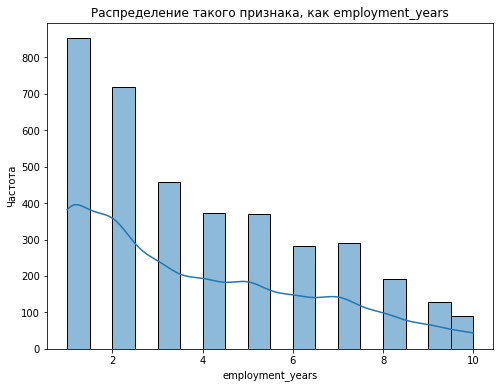

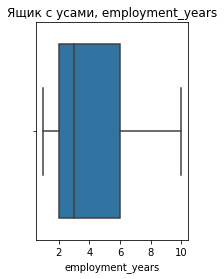

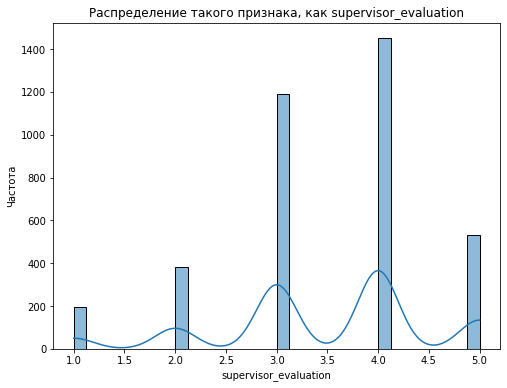

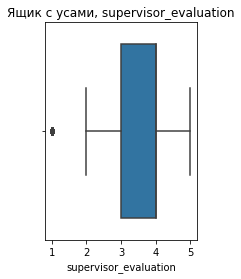

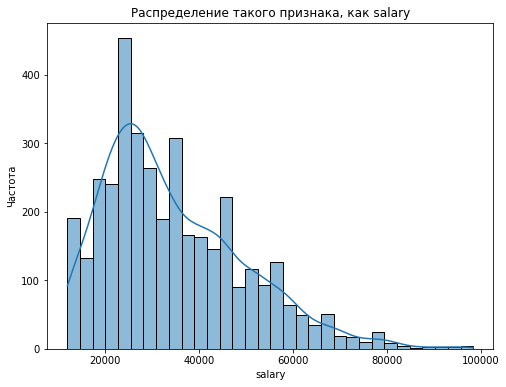

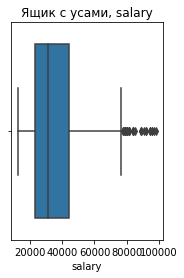

In [57]:
for column in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(train[column], kde=True)
    plt.title(f'Распределение такого признака, как {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=train[column])
    plt.title(f'Ящик с усами, {column}')
    plt.xlabel(column)
    
    plt.show()

В столбце с зарплатой видим огромное количество выбросов: необходимо посмотреть, что это за значения:

In [58]:
display(train[train['salary'] > 80000])

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
45,technology,senior,high,3,no,no,1,84000,0.21
141,marketing,senior,high,7,no,no,3,80400,0.48
360,marketing,senior,high,7,no,no,2,81600,0.58
1241,technology,senior,high,4,no,no,4,94800,0.67
1718,purchasing,senior,high,9,no,yes,4,80400,0.66
1799,marketing,senior,high,10,no,no,4,84000,0.81
1855,technology,senior,high,6,no,yes,4,88800,0.74
1899,technology,senior,high,6,no,no,5,88800,0.83
1981,technology,senior,high,9,no,no,3,84000,0.40
1982,technology,senior,high,7,no,no,1,92400,0.45


Столь отклоняющиеся от правила трех сигм значения зарплат сотрудников действительно имею место быть: они senior-ы и работы у них невпроворот ;(

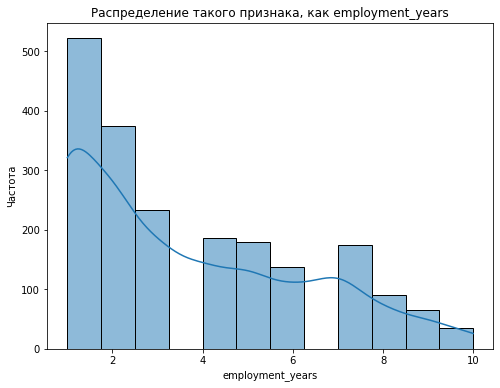

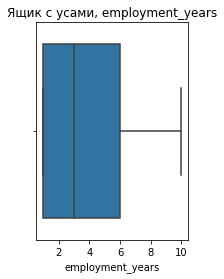

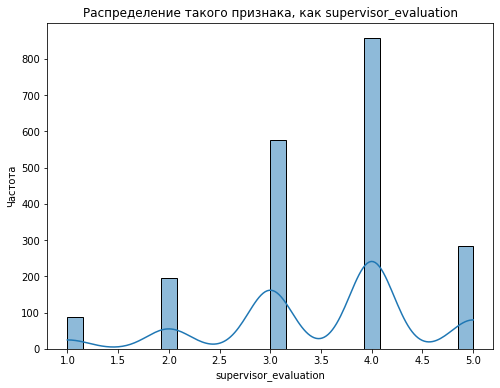

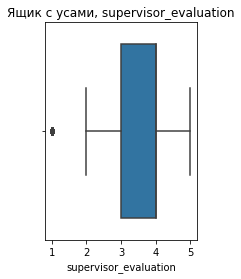

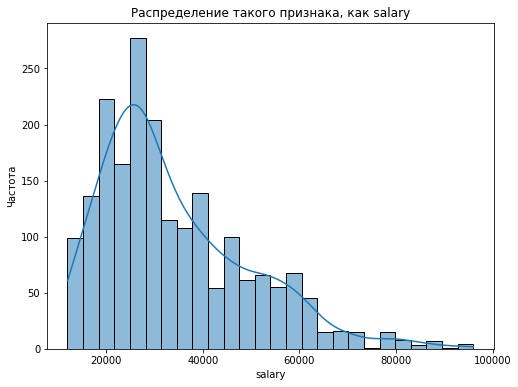

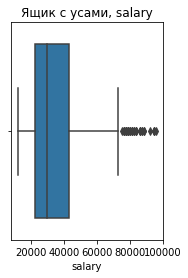

In [59]:
for column in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(test[column], kde=True)
    plt.title(f'Распределение такого признака, как {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=test[column])
    plt.title(f'Ящик с усами, {column}')
    plt.xlabel(column)
    
    plt.show()

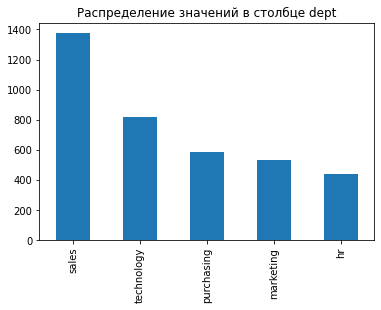

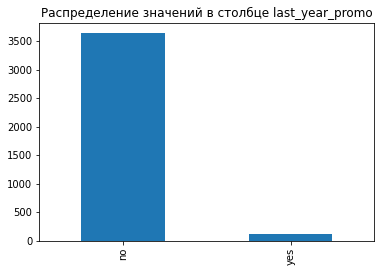

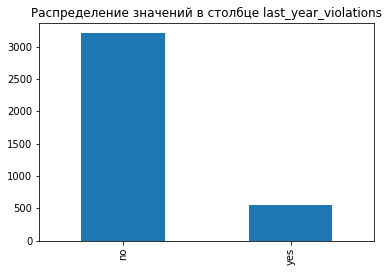

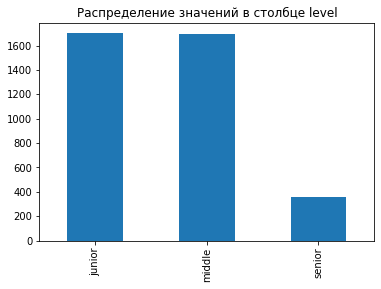

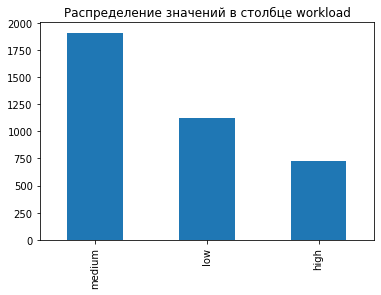

In [60]:
for column in non_numeric_columns:
    train[column].value_counts().plot(kind='bar', x=column)
    plt.title(f'Распределение значений в столбце {column}')
    plt.show()

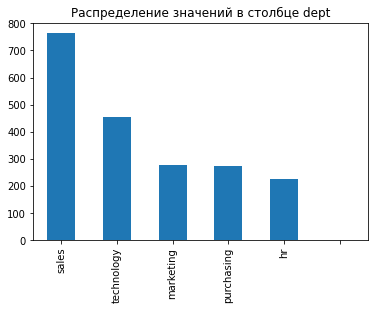

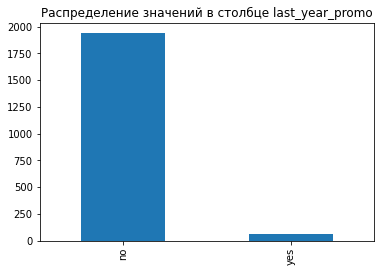

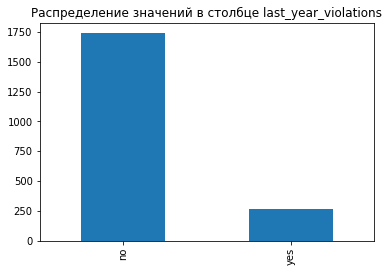

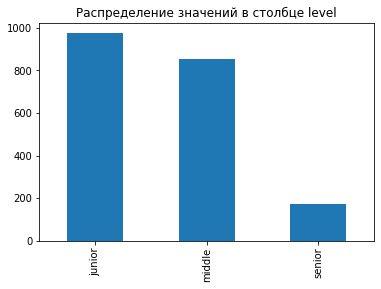

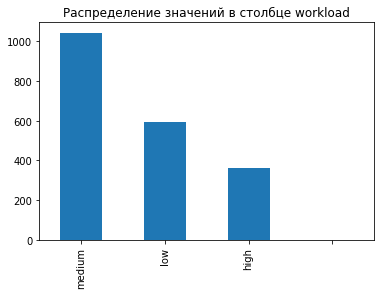

In [61]:
for column in non_numeric_columns:
    test[column].value_counts().plot(kind='bar', x=column)
    plt.title(f'Распределение значений в столбце {column}')
    plt.show()

Вывод: распределение данных в тренировочных и тестовых выборках практически идентичны6 модель должна работать хорошо.

## Шаг 4. Корреляционный анализ

Также проведем корреляционный анализ, для того, чтобы посмотреть, одинаковы ли зависимости между входными и целевым признаками в тренировочной и тестовой выборках:

In [62]:
interval_cols = ['salary', 'job_satisfaction_rate']

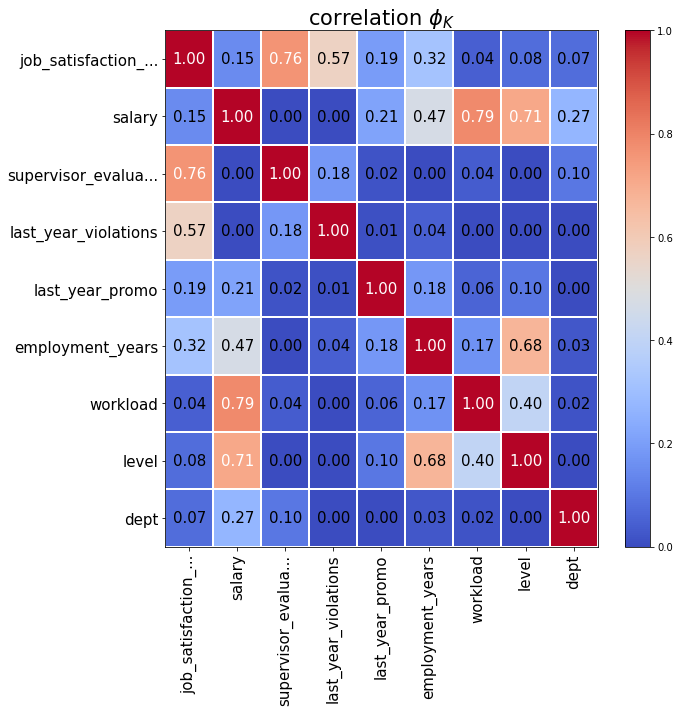

In [63]:
phik_overview = phik_matrix(train, interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='coolwarm',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(10, 10)
)

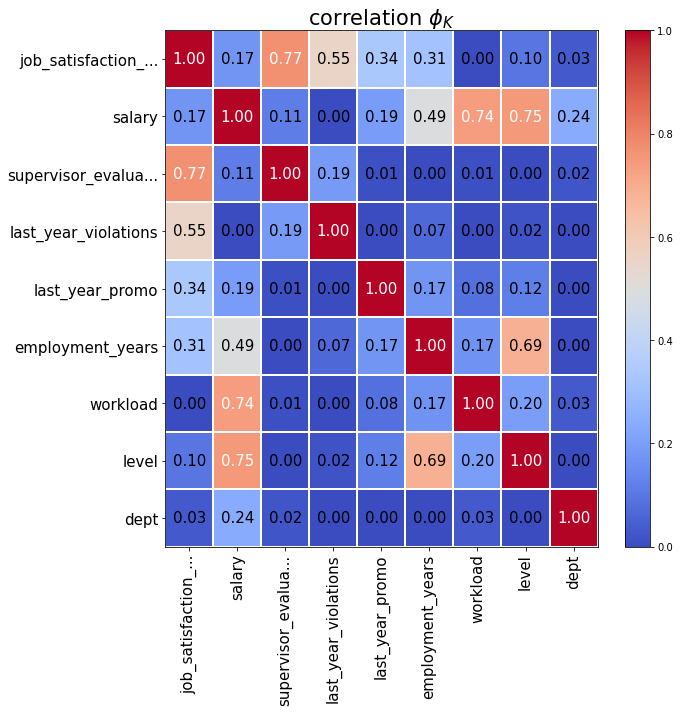

In [64]:
phik_overview = phik_matrix(test, interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='coolwarm',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(10, 10)
)

Вывод: с небольшими, но не столь значительными отклонениями зависимость между входными и целевым призаками в обеих выборках практически идентичны. Время приступать к обучению моделей!

## Шаг 5. Подготовка данных и обучение моделей

In [65]:
RANDOM_STATE=42

X_train = train.drop('job_satisfaction_rate', axis=1)
y_train = train['job_satisfaction_rate']
X_test = test.drop('job_satisfaction_rate', axis=1)
y_test = test['job_satisfaction_rate']

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'salary', 'supervisor_evaluation']


In [66]:
ohe_pipe = Pipeline(
    [
        (
            'simpleimputer_ohe_nan_1',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'simpleimputer_ohe_space', 
            SimpleImputer(missing_values=" ", strategy='constant', fill_value=np.nan)
        ),
        (
            'simpleImputer_ohe_nan_2',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
)

ord_pipe = Pipeline(
    [
        (
            'simpleimputer_before_ord_nan_1',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ), 
        (
            'simpleimputer_before_ord_space',
            SimpleImputer(missing_values=" ", strategy='constant', fill_value=np.nan)
        ), 
        (
            'simpleimputer_before_ord_nan_2',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories=[
                ['junior', 'middle','senior'],
                ['low', 'medium', 'high']
            ], handle_unknown='use_encoded_value', unknown_value=np.nan)
        ), 
        (
            'simpleimputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [67]:
param_grid = [
    {
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': range(2, 15),
        'model__min_samples_split': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    {
        'model': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]



In [68]:
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred))/2))

smape_scorer = make_scorer(smape, greater_is_better=False)

random_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleimputer_ohe_nan_1',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('simpleimputer_ohe_space',
                                                                                                SimpleImputer(fill_value=nan,
                                                                                                              missing_values=' ',
                                                                                                              strategy='constant')),
                                                                                               ('simpleImputer_ohe_nan_2',
                                                                                                SimpleImputer(...
                                         'model__max_depth': range(2, 15),
                                         'model__min_samples_split': range(2, 15),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'model': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [69]:
print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
print ('Метрика лучшей модели при кросс-валидации:', np.abs(random_search.best_score_))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleimputer_ohe_nan_1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleimputer_ohe_space',
                                                                   SimpleImputer(fill_value=nan,
                                                                                 missing_values=' ',
                                                                                 strategy='constant')),
                                                                  ('simpleImputer_ohe_nan_2',
                                                                   SimpleImputer(strategy='most_frequent')),
                

Таким образом, лучшая модель - DecisionTreeRegressor со следующими гиперпараметрами: максимальная глубина = 14 и минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться, = 7

In [70]:
y_pred = random_search.best_estimator_.predict(X_test)
smape_test = smape(y_test, y_pred)

print('Значение метрики SMAPE на тестовой выборке:', smape_test)

Значение метрики SMAPE на тестовой выборке: 13.811977236217963


Получено достойное значение SMAPE!

## Шаг 6. Промежуточный вывод

In [71]:
pd.set_option('display.max_colwidth', None)
results_df = pd.DataFrame(random_search.cv_results_)[['rank_test_score', 'mean_test_score','params']]\
            .sort_values('rank_test_score')
results_df

,rank_test_score,mean_test_score,params
0,1,-15.218877,"{'preprocessor__num': 'passthrough', 'model__min_samples_split': 7, 'model__max_depth': 14, 'model': DecisionTreeRegressor(random_state=42)}"
8,2,-15.396472,"{'preprocessor__num': 'passthrough', 'model__min_samples_split': 10, 'model__max_depth': 14, 'model': DecisionTreeRegressor(random_state=42)}"
5,3,-15.400172,"{'preprocessor__num': RobustScaler(), 'model__min_samples_split': 7, 'model__max_depth': 12, 'model': DecisionTreeRegressor(random_state=42)}"
1,4,-15.443761,"{'preprocessor__num': 'passthrough', 'model__min_samples_split': 10, 'model__max_depth': 13, 'model': DecisionTreeRegressor(random_state=42)}"
9,5,-15.511602,"{'preprocessor__num': MinMaxScaler(), 'model__min_samples_split': 6, 'model__max_depth': 11, 'model': DecisionTreeRegressor(random_state=42)}"
3,6,-17.202370,"{'preprocessor__num': 'passthrough', 'model__min_samples_split': 3, 'model__max_depth': 8, 'model': DecisionTreeRegressor(random_state=42)}"
6,7,-18.343774,"{'preprocessor__num': StandardScaler(), 'model__min_samples_split': 2, 'model__max_depth': 7, 'model': DecisionTreeRegressor(random_state=42)}"
7,8,-20.194110,"{'preprocessor__num': MinMaxScaler(), 'model__min_samples_split': 4, 'model__max_depth': 5, 'model': DecisionTreeRegressor(random_state=42)}"
2,9,-22.691739,"{'preprocessor__num': 'passthrough', 'model__min_samples_split': 4, 'model__max_depth': 3, 'model': DecisionTreeRegressor(random_state=42)}"
4,9,-22.691739,"{'preprocessor__num': MinMaxScaler(), 'model__min_samples_split': 14, 'model__max_depth': 3, 'model': DecisionTreeRegressor(random_state=42)}"


В таблице представлены все модели, которые были в пайплайне, в столбце **mean_test_score** указы значения метрики SMAPE на валидационной выборке для каждой из них.

Из всех имеющихся моделей для решения задачи предсказания уровня удовлетворенности сотрудника работой лучшей моделью действительно оказалась DecisionTreeRegressor с максимальной глубиной = 14 и минимальным число объектов, необходимым для того, чтобы узел дерева мог бы расщепиться, = 7, так как метрика SMAPE по модулю у нее минимальная

# Задача 2: предсказание увольнения сотрудника из компании

## Шаг 1. Загрузка данных

Загрузим данные и прямо на этом же этапе объединим входные и целевой признаки тестовой выборки.

In [72]:
train_2 = pd.read_csv('/datasets/train_quit.csv')
display(train_2.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [73]:
test_2 = pd.read_csv('/datasets/test_features.csv')
display(test_2.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [74]:
target_2 = pd.read_csv('/datasets/test_target_quit.csv')
display(target_2.head())

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [75]:
test_2 = test_2.merge(target_2, on='id', how='left')
display(test_2.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,no
1,686555,hr,junior,medium,1,no,no,4,30000,no
2,467458,sales,middle,low,5,no,no,4,19200,no
3,418655,sales,middle,low,6,no,no,4,19200,no
4,789145,hr,middle,medium,5,no,no,5,40800,no


## Шаг 2. Предобработка данных

Проверим типы данных в столбцах, наличие явных и неявных дубликатов, а также опечаток.

In [76]:
train_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [77]:
test_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
 9   quit                   2000 non-null   object
dtypes: int64(4), object(6)
memory usage: 171.9+ KB


In [78]:
train_2.duplicated().sum()

0

In [79]:
test_2.duplicated().sum()

0

Здесь и далее дубликаты из тестовой выборки удалять не будем, так как необходимо предсказать занчения для каждого элемента таблицы.

In [80]:
cat_columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']
for column in cat_columns:
    train_2[column] = train_2[column].str.lower()
    print(f'Уникальные значения в столбце {column}: {train_2[column].unique()}')

Уникальные значения в столбце dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения в столбце level: ['middle' 'junior' 'sinior']
Уникальные значения в столбце workload: ['high' 'medium' 'low']
Уникальные значения в столбце last_year_promo: ['no' 'yes']
Уникальные значения в столбце last_year_violations: ['no' 'yes']
Уникальные значения в столбце quit: ['no' 'yes']


In [81]:
train_2['level'] = train_2['level'].replace('sinior', 'senior')
train_2['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

In [82]:
cat_columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']
for column in cat_columns:
    test_2[column] = test_2[column].str.lower()
    print(f'Уникальные значения в столбце {column}: {test_2[column].unique()}')

Уникальные значения в столбце dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уникальные значения в столбце level: ['junior' 'middle' 'sinior' nan]
Уникальные значения в столбце workload: ['medium' 'low' 'high' ' ']
Уникальные значения в столбце last_year_promo: ['no' 'yes']
Уникальные значения в столбце last_year_violations: ['no' 'yes']
Уникальные значения в столбце quit: ['no' 'yes']


In [83]:
test_2['level'] = test_2['level'].replace('sinior', 'senior')
test_2['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

Предобработка данных завершена!

## Шаг 3. Исследовательский анализ данных

Исследуем данные так же, как в предыдущей задаче: проверим, совпадают ли распределения значений в тренировочной и тестовой выборках, посмотрим на взаимосвязи воходных и целевого признаков.

In [84]:
numeric_columns_2 = ['employment_years', 'supervisor_evaluation', 'salary']
non_numeric_columns_2 = ['dept', 'last_year_promo', 'last_year_violations', 'level', 'workload', 'quit']

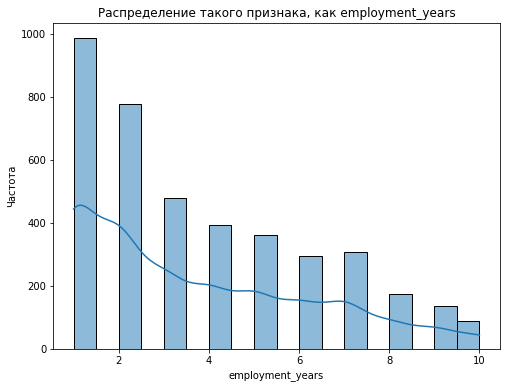

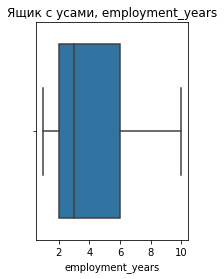

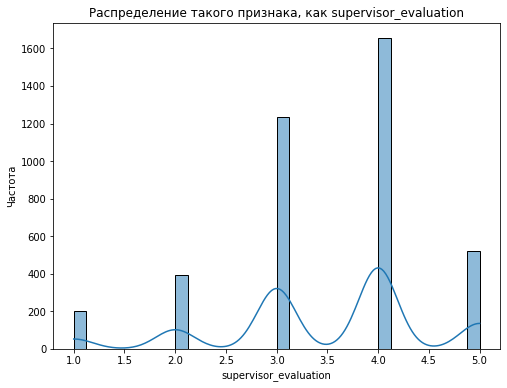

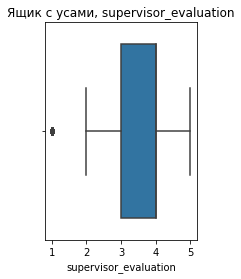

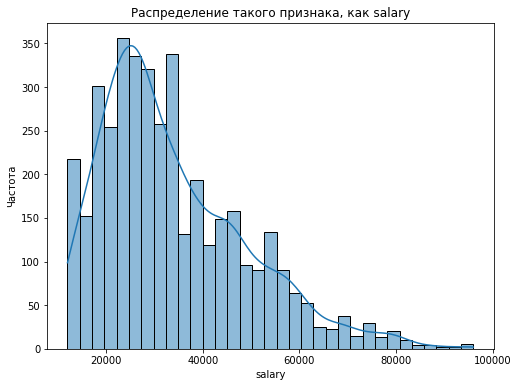

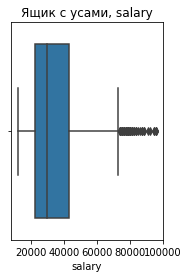

In [85]:
for column in numeric_columns_2:
    plt.figure(figsize=(8, 6))
    sns.histplot(train_2[column], kde=True)
    plt.title(f'Распределение такого признака, как {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=train_2[column])
    plt.title(f'Ящик с усами, {column}')
    plt.xlabel(column)
    
    plt.show()

In [86]:
display(train_2[train_2['salary'] > 80000])

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
16,113657,technology,senior,high,5,yes,no,3,82800,no
179,208223,technology,senior,high,7,no,no,3,94800,no
185,694599,technology,senior,high,1,no,no,4,96000,no
286,638931,technology,senior,high,10,no,no,4,88800,no
323,740852,technology,senior,high,8,no,no,4,96000,no
648,349559,marketing,senior,high,6,yes,no,4,84000,no
700,540037,hr,senior,high,10,no,no,4,81600,no
729,312375,technology,senior,high,10,no,no,4,87600,no
826,953791,technology,senior,high,4,no,no,2,91200,no
925,172759,technology,senior,high,6,no,no,4,96000,no


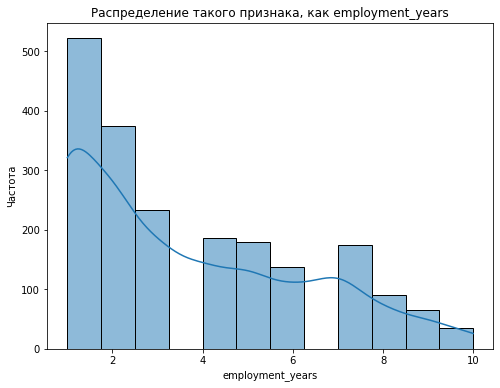

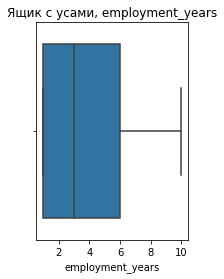

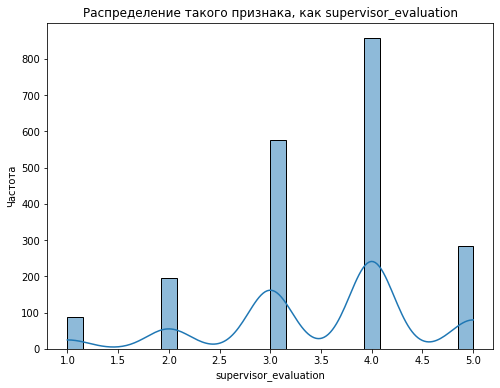

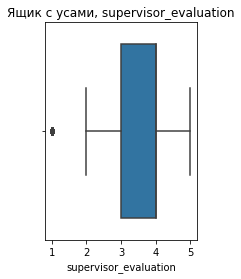

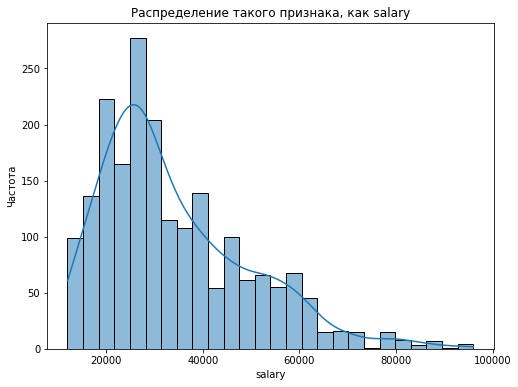

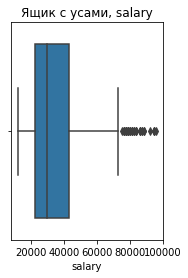

In [87]:
for column in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(test_2[column], kde=True)
    plt.title(f'Распределение такого признака, как {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=test_2[column])
    plt.title(f'Ящик с усами, {column}')
    plt.xlabel(column)
    
    plt.show()

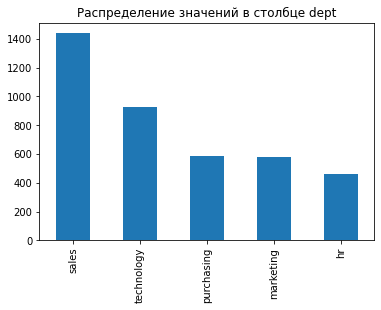

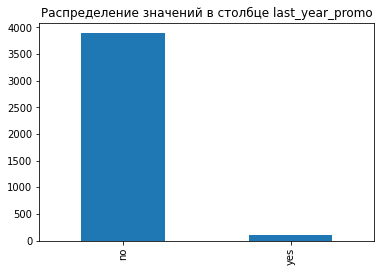

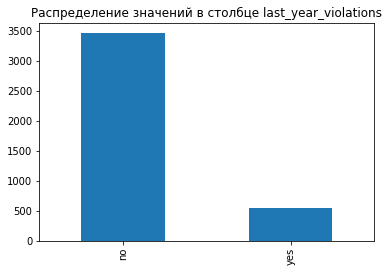

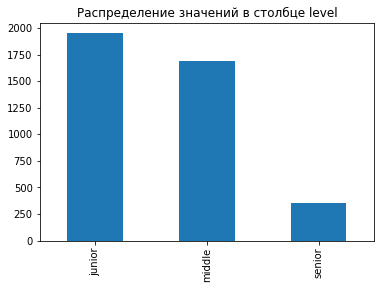

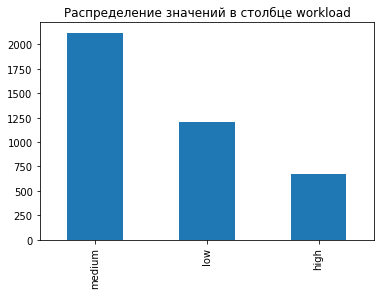

In [88]:
for column in non_numeric_columns:
    train_2[column].value_counts().plot(kind='bar', x=column)
    plt.title(f'Распределение значений в столбце {column}')
    plt.show()

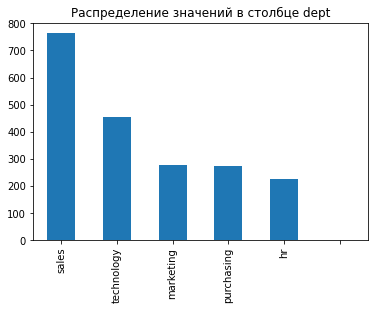

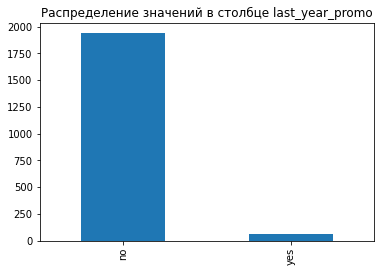

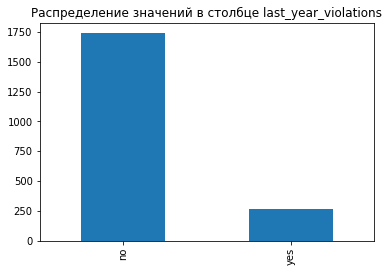

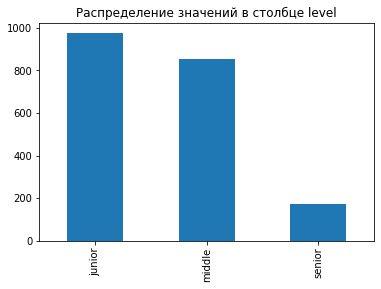

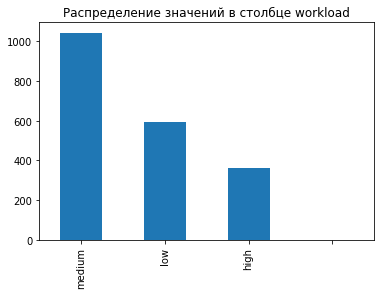

In [89]:
for column in non_numeric_columns:
    test_2[column].value_counts().plot(kind='bar', x=column)
    plt.title(f'Распределение значений в столбце {column}')
    plt.show()

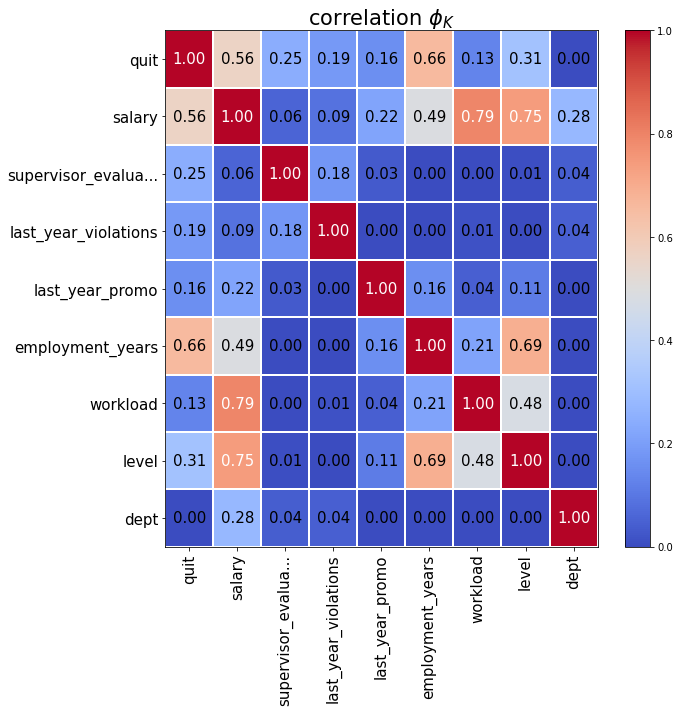

In [90]:
phik_overview = phik_matrix(train_2.drop('id', axis=1), interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='coolwarm',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(10, 10)
)

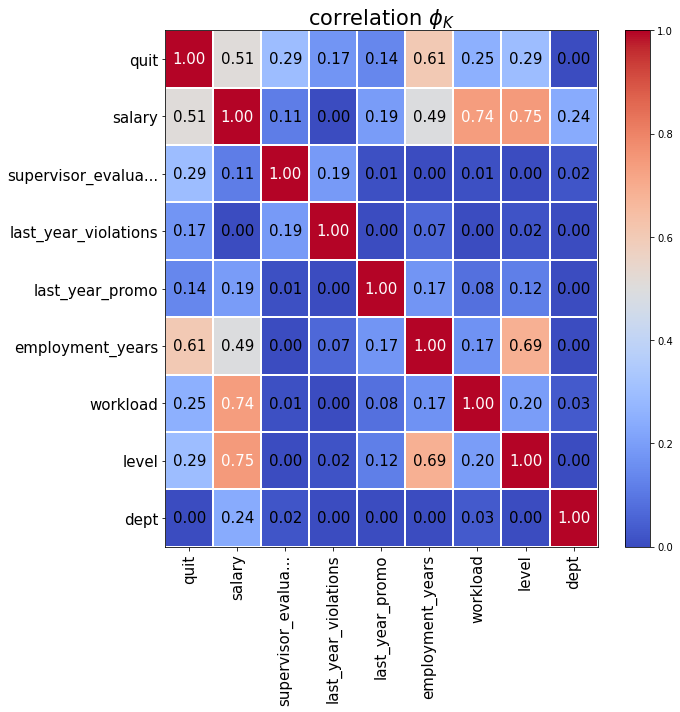

In [91]:
phik_overview = phik_matrix(test_2.drop('id', axis=1), interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='coolwarm',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(10, 10)
)

Структура данных в обеих выборках очень схожа, модель будет работать адекватно.

### Портрет уволившегося сотрудника 

In [92]:
resigned = train_2[train_2['quit'] == 'yes']
not_resigned = train_2[train_2['quit'] == 'no']

Посмотрим, каковы отличительные особенности сотрудника, который уволился из компании с помощью круговых диаграмм:

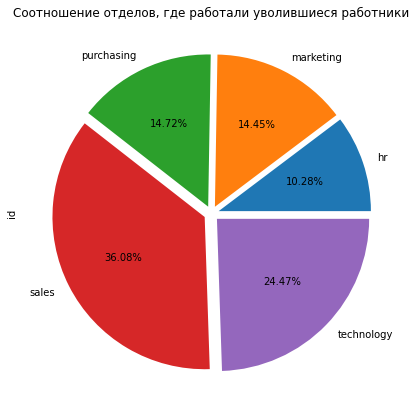

In [93]:
resigned.groupby(by='dept').count()['id'].plot(
    kind='pie', 
    autopct='%1.2f%%', 
    explode=(0.05, 0.05, 0.05, 0.05, 0.05), 
    title='Соотношение отделов, где работали уволившиеся работники',
    figsize=(7, 7)
)
plt.show()

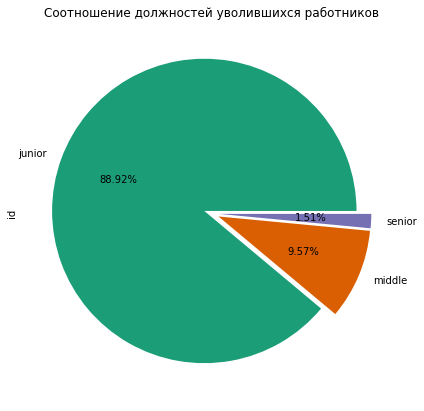

In [94]:
resigned.groupby(by='level').count()['id'].plot(
    kind='pie', 
    autopct='%1.2f%%', 
    explode=(0.05, 0.05, 0.05), 
    title='Соотношение должностей уволившихся работников',
    figsize=(7, 7), 
    colors=plt.cm.Dark2.colors
)
plt.show()

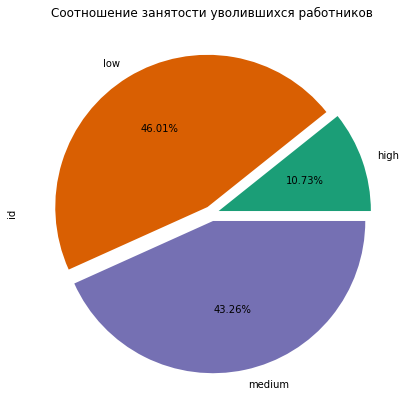

In [95]:
resigned.groupby(by='workload').count()['id'].plot(
    kind='pie', 
    autopct='%1.2f%%', 
    explode=(0.05, 0.05, 0.05), 
    title='Соотношение занятости уволившихся работников',
    figsize=(7, 7), 
    colors=plt.cm.Dark2.colors
)
plt.show()

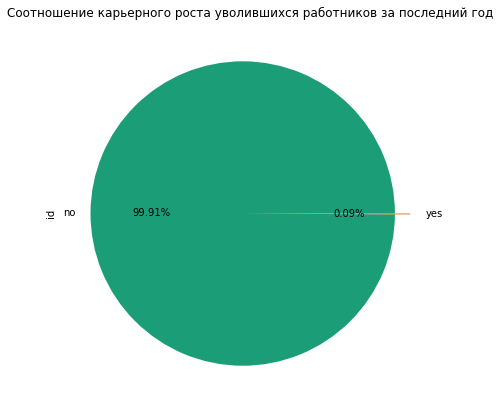

In [96]:
resigned.groupby(by='last_year_promo').count()['id'].plot(
    kind='pie', 
    autopct='%1.2f%%', 
    explode=(0.05, 0.05), 
    title='Соотношение карьерного роста уволившихся работников за последний год',
    figsize=(7, 7), 
    colors=plt.cm.Dark2.colors
)
plt.show()

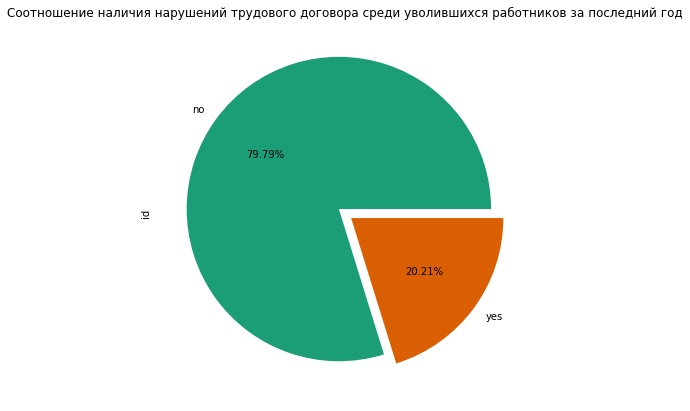

In [97]:
resigned.groupby(by='last_year_violations').count()['id'].plot(
    kind='pie', 
    autopct='%1.2f%%', 
    explode=(0.05, 0.05), 
    title='Соотношение наличия нарушений трудового договора среди уволившихся работников за последний год',
    figsize=(7, 7), 
    colors=plt.cm.Dark2.colors
)
plt.show()

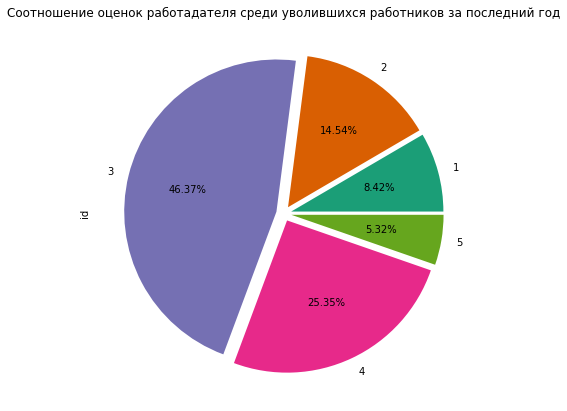

In [98]:
resigned.groupby(by='supervisor_evaluation').count()['id'].plot(
    kind='pie', 
    autopct='%1.2f%%', 
    explode=(0.05, 0.05, 0.05, 0.05, 0.05), 
    title='Соотношение оценок работадателя среди уволившихся работников за последний год',
    figsize=(7, 7), 
    colors=plt.cm.Dark2.colors
)
plt.show()

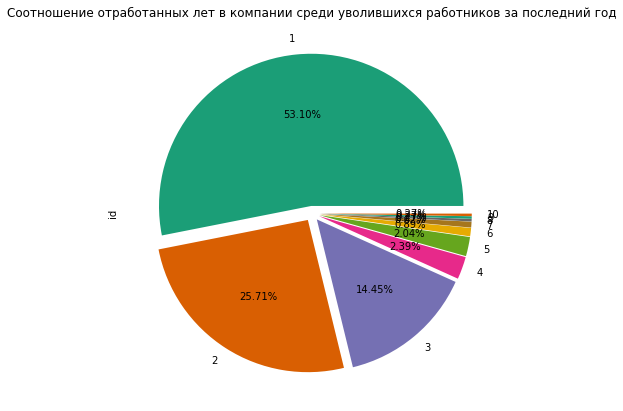

In [99]:
resigned.groupby(by='employment_years').count()['id'].plot(
    kind='pie', 
    autopct='%1.2f%%', 
    explode=(0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05), 
    title='Соотношение отработанных лет в компании среди уволившихся работников за последний год',
    figsize=(7, 7), 
    colors=plt.cm.Dark2.colors
)
plt.show()

Из полученных диаграмм можно сделать следующий вывод: работник, уволившийся из компании, скорее всего работал в отделе продаж, был junior-ом, его рабочая нагрузка была низкой, в компании он проработал год, не получал повышения в прошлом году (скорее всего, потому что в прошлом году и не работал), не нарушал трудовой договор и его качество работы было оценено руководителем на 3 из 5.

Посмотрим, что из себя представляет зарплата в разных отделах:

In [101]:
resigned[(resigned['level'] == 'junior') & 
        (resigned['workload'] == 'low')].pivot_table(index='dept', values='salary', aggfunc='mean')

,salary
dept,
hr,15882.352941
marketing,15521.311475
purchasing,15037.500000
sales,14721.428571
technology,18576.000000


Нетрудно заметить, что самая низкая зарплата в отделе продаж, а самая высокая - в технологическом отделе

Также следует рассмотреть зарплату типового уволившегося сотрудника и сравнить его со средней зарплатой по компании:

In [102]:
filtered_employee = resigned[(resigned['dept'] == 'sales') & 
                       (resigned['level'] == 'junior') &
                       (resigned['workload'] == 'low') & 
                       (resigned['employment_years'] == 1) & 
                       (resigned['last_year_violations'] == 'no') & 
                       (resigned['supervisor_evaluation'] == 3)]

average_salary_filtered = filtered_employee['salary'].mean()

average_salary_not_resigned = not_resigned['salary'].mean()

print("Средняя зарплата у типового уволившегося сотрудника:", average_salary_filtered)
print("Средняя зарплата у сотрудников, которые не уволились:", round(average_salary_not_resigned, 2))
print("Разница в зарплате", round(round(average_salary_not_resigned, 2)/average_salary_filtered, 2))

Средняя зарплата у типового уволившегося сотрудника: 14888.888888888889
Средняя зарплата у сотрудников, которые не уволились: 37702.23
Разница в зарплате 2.53


Средний работающий в компании сотрудник зарабатывает аж в три раза больше среднего уволившегося! Есть, о чем подумать...

Недурно будет также посмотреть, влияет ли удовлетворенность работой на факт увольнения, и если да, то как. Займемся этим!

In [103]:
satisfaction_n_quit = target.merge(target_2, on='id', how='left')
satisfaction_n_quit

,id,job_satisfaction_rate,quit
0,130604,0.74,no
1,825977,0.75,no
2,418490,0.60,yes
3,555320,0.72,no
4,826430,0.08,yes
...,...,...,...
1995,405257,0.28,no
1996,370925,0.21,yes
1997,857722,0.39,no
1998,303402,0.26,yes


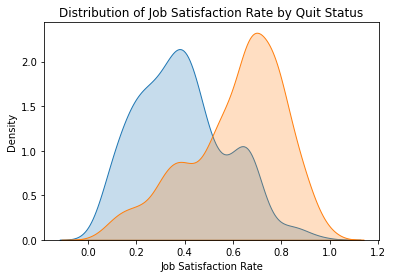

In [104]:
sns.kdeplot(data=satisfaction_n_quit[satisfaction_n_quit['quit'] == 'yes']['job_satisfaction_rate'], label='Quit', shade=True)

sns.kdeplot(data=satisfaction_n_quit[satisfaction_n_quit['quit'] == 'no']['job_satisfaction_rate'], label='Stayed', shade=True)

plt.title('Distribution of Job Satisfaction Rate by Quit Status')
plt.xlabel('Job Satisfaction Rate')
plt.ylabel('Density')

plt.show()

Вывод: нетрудно заметить, что если удовлетворенность работой ниже 0.5, то велик шанс увольнения; это работает и в обратную сторону

## Шаг 4. Добавление нового входного признака

In [105]:
train_2 = train_2.drop('id', axis=1)
test_2 = test_2.drop('id', axis=1)

In [106]:
train_2.duplicated().sum()

1413

In [107]:
train_2 = train_2.drop_duplicates()
train_2.duplicated().sum()

0

В связи с выявленной зависимостью между увдовлетворенностью работой и фактов увольнения, добавим новый входной признак для улучшения работы модели:

In [108]:
new_train_col = random_search.predict(train_2)
train_2['job_satisfaction_rate'] = new_train_col
display(train_2.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,sales,middle,high,2,no,no,4,54000,no,0.653333
1,sales,junior,medium,2,no,no,4,27600,no,0.848000
2,purchasing,middle,medium,5,no,no,1,37200,no,0.340000
3,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,marketing,junior,medium,2,no,no,5,25200,no,0.690000


In [109]:
new_test_col = random_search.predict(test_2)
test_2['job_satisfaction_rate'] = new_test_col
display(test_2.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,marketing,junior,medium,2,no,no,5,28800,no,0.855000
1,hr,junior,medium,1,no,no,4,30000,no,0.676667
2,sales,middle,low,5,no,no,4,19200,no,0.654000
3,sales,middle,low,6,no,no,4,19200,no,0.655000
4,hr,middle,medium,5,no,no,5,40800,no,0.816667


## Шаг 5. Подготовка данных и обучение модели

In [110]:
RANDOM_STATE=42

X_train = train_2.drop(['quit'], axis=1)
y_train = train_2['quit']
X_test = test_2.drop(['quit'], axis=1)
y_test = test_2['quit']

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [111]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'salary', 'supervisor_evaluation', 'job_satisfaction_rate']

ohe_pipe = Pipeline(
    [
        (
            'simpleimputer_ohe_nan_1',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'simpleimputer_ohe_space', 
            SimpleImputer(missing_values=" ", strategy='constant', fill_value=np.nan)
        ),
        (
            'simpleImputer_ohe_nan_2',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
)

ord_pipe = Pipeline(
    [
        (
            'simpleimputer_before_ord_nan_1',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ), 
        (
            'simpleimputer_before_ord_space',
            SimpleImputer(missing_values=" ", strategy='constant', fill_value=np.nan)
        ), 
        (
            'simpleimputer_before_ord_nan_2',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories=[
                ['junior', 'middle','senior'],
                ['low', 'medium', 'high']
            ], handle_unknown='use_encoded_value', unknown_value=np.nan)
        ), 
        (
            'simpleimputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)
 
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': [0, 0.1, 0.5, 1, 3],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['rbf','sigmoid', 'linear', 'poly'],
        'models__C': [0, 0.1, 0.5, 1, 3],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],        
    }
]

In [112]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
 
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleimputer_ohe_nan_1',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('simpleimputer_ohe_space',
                                                                                                SimpleImputer(fill_value=nan,
                                                                                                              missing_values=' ',
                                                                                                              strategy='constant')),
                                                                                               ('simpleImputer_ohe_nan_2',
                                                                                                SimpleImputer(...
                                                                       solver='liblinear')],
                                         'models__C': [0, 0.1, 0.5, 1, 3],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__C': [0, 0.1, 0.5, 1, 3],
                                         'models__kernel': ['rbf', 'sigmoid',
                                                            'linear', 'poly'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [113]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели при кросс-валидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleimputer_ohe_nan_1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleimputer_ohe_space',
                                                                   SimpleImputer(fill_value=nan,
                                                                                 missing_values=' ',
                                                                                 strategy='constant')),
                                                                  ('simpleImputer_ohe_nan_2',
                                                                   SimpleImputer(strategy='most_frequent')),
                

Лучшей моделью оказалось дерево решений с глубиной, равной 4, и числом признаков, по которым ищется разбиение, равным 12.

In [114]:
y_test_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_proba[:,1])}')

Метрика ROC-AUC на тестовой выборке: 0.9136774234971058


Получено достойное значение ROC-AUC: в 91 случае из 100 модель верно предсказывает факт увольнения сотрудника из компании!

## Шаг 6. Промежуточный вывод

In [115]:
pd.set_option('display.max_colwidth', None)
results_df = pd.DataFrame(randomized_search.cv_results_)[['rank_test_score', 'param_models', 'mean_test_score','params']]\
            .sort_values('rank_test_score')
results_df

,rank_test_score,param_models,mean_test_score,params
4,1,DecisionTreeClassifier(random_state=42),0.898393,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 12, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}"
0,2,DecisionTreeClassifier(random_state=42),0.893124,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 5, 'models__max_depth': 3, 'models': DecisionTreeClassifier(random_state=42)}"
9,3,KNeighborsClassifier(),0.884473,"{'preprocessor__num': 'passthrough', 'models__n_neighbors': 10, 'models': KNeighborsClassifier()}"
2,4,DecisionTreeClassifier(random_state=42),0.869378,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 3, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}"
6,5,DecisionTreeClassifier(random_state=42),0.856518,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 13, 'models__max_depth': 8, 'models': DecisionTreeClassifier(random_state=42)}"
3,6,DecisionTreeClassifier(random_state=42),0.845678,"{'preprocessor__num': 'passthrough', 'models__max_features': 12, 'models__max_depth': 9, 'models': DecisionTreeClassifier(random_state=42)}"
8,7,DecisionTreeClassifier(random_state=42),0.831574,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 7, 'models__max_depth': 10, 'models': DecisionTreeClassifier(random_state=42)}"
7,8,DecisionTreeClassifier(random_state=42),0.828179,"{'preprocessor__num': 'passthrough', 'models__max_features': 2, 'models__max_depth': 11, 'models': DecisionTreeClassifier(random_state=42)}"
5,9,"SVC(probability=True, random_state=42)",0.667882,"{'preprocessor__num': 'passthrough', 'models__kernel': 'poly', 'models__C': 1, 'models': SVC(probability=True, random_state=42)}"
1,10,"SVC(probability=True, random_state=42)",0.629625,"{'preprocessor__num': 'passthrough', 'models__kernel': 'poly', 'models__C': 0.1, 'models': SVC(probability=True, random_state=42)}"


# Общий вывод

В работе над проектом были выполнены следующие этапы: загрузка данных, их предобработка, которая включила в себя объединение входных и целевого признаков тестовых выборок, обработка дубликатов и опечаток, а также обучение и отбор лучшей моделей, с помощью которых предсказывалось два параметра: удовлетворенность сотрудника работой и вероятность его увольнения. Оказалось, что предсказанные в первой задаче значения напрямую влияют на значения, предсказываемые во второй задаче, поэтому было важно оценить работу моделей на каждом из этапов соответствующей метрикой.


Также была проведена сегментация работников и был составлен портрет уволившегося сотрудника. Оказалось, что наиболее часто увольняются junior-ы из отдела продаж, зарплата которых практически в три раза меньше зарплаты среднего работника в компании. Также подвержены увольнению работники технологического отдела, несмотря на самую высокую зарплату по компании в этом департаменте. 

В связи с проведенным анализом логичным будет предложить компании провести анализ  оценки и награждений для сотрудников отдела продаж и составить план адаптации junior-ов для продолжения их карьеры в компании. Безусловно, стоит также разработать программу, которая будет сближать коллектив и предусмотреть различные варианты решения конфликтных ситуаций (как связанных с оценкой работы сотрудника, за которой потом следует начисление зарплаты, так и связанных с взаимодействиями между коллегами). 

По итогу анализа я бы рекомендовала компании разгрузить senior-ов, настроить коммуникацию между ними и менее опытными сотрудниками, организовать институт наставничества и развивать лояльность сотрудников к компании посредством различных мероприятий и проектов. 